<a href="https://colab.research.google.com/github/rohitblpprajapat/100-days-of-code/blob/master/MNIST_CLASSIFICATION_SGDRegressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
np.random.seed(42)

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier, RidgeClassifier, LogisticRegression
from sklearn.model_selection import cross_validate, RandomizedSearchCV, cross_val_predict
from sklearn.metrics import log_loss, ConfusionMatrixDisplay, precision_score, recall_score, classification_report, precision_recall_curve, roc_curve, roc_auc_score

In [3]:
from scipy.stats import loguniform

In [4]:
#visualizations
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


#global settings
mpl.rc('axes',labelsize=14)
mpl.rc('xtick',labelsize=12)
mpl.rc('ytick',labelsize=12)
mpl.rc('figure',figsize=(8,6))

# Handwritten Digit Classification

In [5]:
from sklearn.datasets import fetch_openml
x_pd, y_pd = fetch_openml('mnist_784', version=1, return_X_y=True)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [6]:
X = x_pd.to_numpy()
y = y_pd.to_numpy()

# Pre-processing

* unlike perceptron, where scaling the range is optional(but recommended), sigmoid requires the feature range between 0 and 1.
* Contemplate the consequences if we don't apply the same scalling operation on the input data
* Note: **Do not** apply mean centering as it removes zeros from the data, however, zeros should be zeros in the dataset.

In [7]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [8]:
print('Mean of the features:', np.mean(X))
print('sd', np.std(X))
print('min', np.min(X))
print('max', np.max(X))

Mean of the features: 0.13092720382627604
sd 0.3084510570135976
min 0.0
max 1.0


In [9]:
target_names = np.unique(y)
target_names

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [10]:
print('Number of samples: {0}, type: {1}'.format(X.shape[0], X.dtype))
print('Number of features: {0}'.format(X.shape[1]))
print('Number of classes: {}, type:{}'.format(len(target_names),y.dtype))
print('Labels: {}'.format(target_names))

Number of samples: 70000, type: float64
Number of features: 784
Number of classes: 10, type:object
Labels: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


# Data Visualization

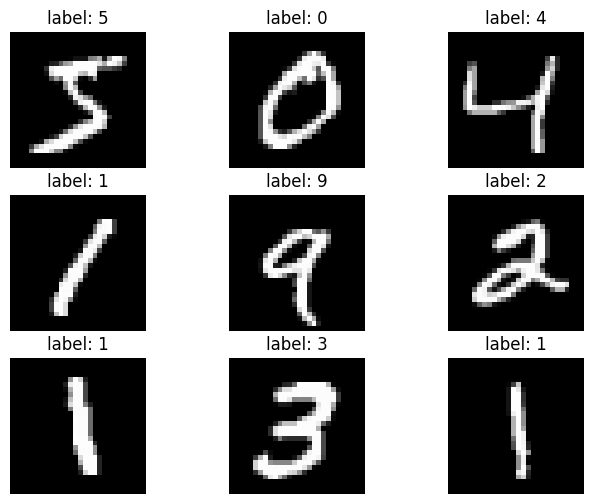

In [11]:
num_images = 15
factor = np.int_(np.sqrt(num_images))
fig, ax = plt.subplots(nrows=factor, ncols=factor, figsize=(8,6))
idx_offset = 0
for i in range(factor):
  index = idx_offset+i*(factor)
  for j in range(factor):
    ax[i,j].imshow(X[index+j].reshape(28,28), cmap='gray')
    ax[i,j].set_title('label: {0}'.format(str(y[index+j])))
    ax[i,j].set_axis_off()

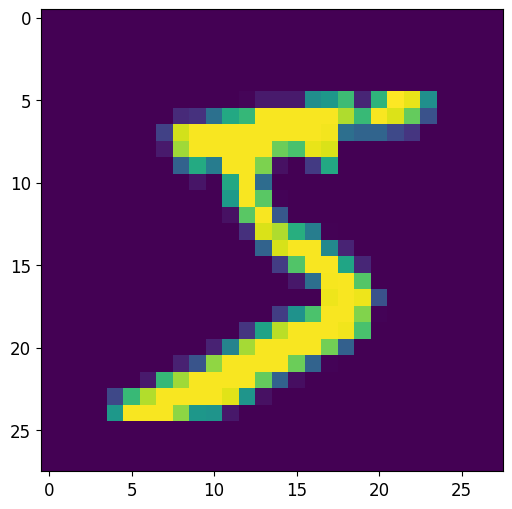

In [12]:
plt.figure(figsize=(6,6))
plt.imshow(X[0].reshape(28,28))
plt.show()


## data spliting

In [13]:
x_train, x_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

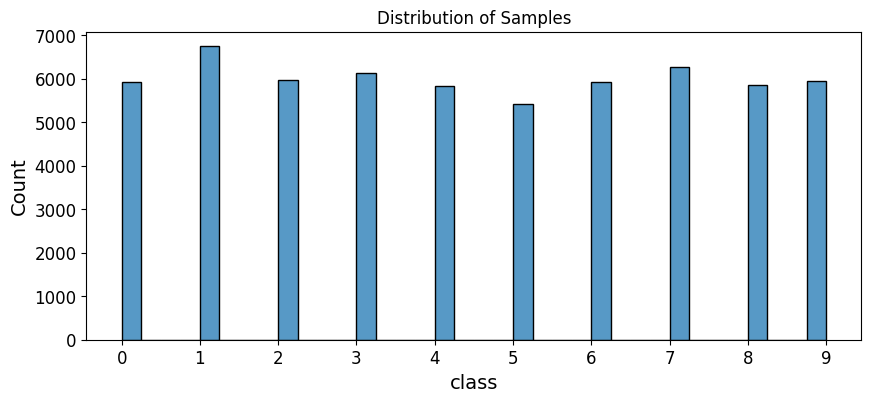

In [14]:
plt.figure(figsize=(10,4))
sns.histplot(np.int8(y_train))
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9], labels=[0,1,2,3,4,5,6,7,8,9])
plt.xlabel('class')
plt.title('Distribution of Samples')
plt.show()

# Binary Classification: 0-Detector

In [15]:
# Initialize new variable names with all -1
y_train_0 = np.zeros((len(y_train)))
y_test_0 = np.zeros((len(y_test)))

# find the indeces of digit 0 image
indx_0 = np.where(y_train == '0')

# use those indices to modify y_train_0 & y_test_0
y_train_0[indx_0] = 1
indx_0 = np.where(y_test == '0')
y_test_0[indx_0] = 1



In [16]:
print(np.where(y_train=='0'))
print(np.where(y_train_0==1))

(array([    1,    21,    34, ..., 59952, 59972, 59987]),)
(array([    1,    21,    34, ..., 59952, 59972, 59987]),)


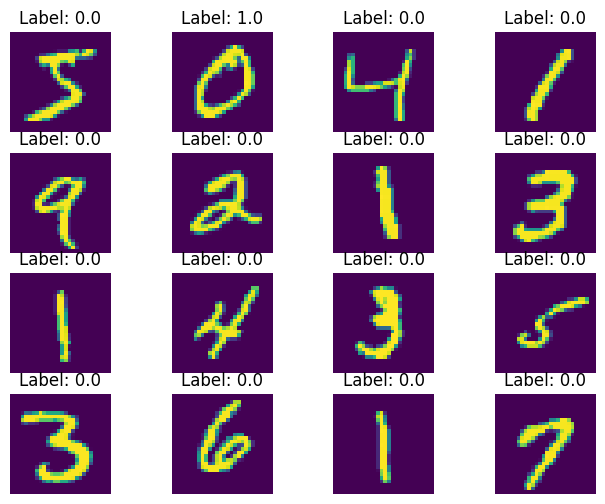

In [17]:
num_images = 16
factor = np.int_(np.sqrt(num_images))
fig,ax = plt.subplots(nrows=factor, ncols=factor, figsize=(8,6))
idx_offset = 0
for i in range(factor):
  index = idx_offset+i*(factor)
  for j in range(factor):
    ax[i,j].imshow(X[index+j].reshape(28,28))
    ax[i,j].set_title('Label: {}'.format(str(y_train_0[index+j])))
    ax[i,j].set_axis_off()

# Baseline Models

In [18]:
np.where(y_train_0==1)

(array([    1,    21,    34, ..., 59952, 59972, 59987]),)

In [19]:
num_pos = len(np.where(y_train_0==1)[0])
num_neg = len(np.where(y_train_0==0)[0])
print(num_pos, num_neg)

5923 54077


In [20]:
base_clf = DummyClassifier(strategy='most_frequent')
base_clf.fit(x_train,y_train_0)
print(base_clf.score(x_train, y_train_0))

0.9012833333333333


## training without regularization

In [21]:
bin_sgd = SGDClassifier(loss='log_loss',
                        penalty='l2',
                        max_iter=1,
                        warm_start=True,
                        eta0=0.01,
                        alpha=0,
                        learning_rate='constant',
                        random_state=1729)
loss=[]
iterations=100
for i in range(iterations):
  bin_sgd.fit(x_train,y_train_0)
  y_pred=bin_sgd.predict_proba(x_train)
  loss.append(log_loss(y_train_0,y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic

In [22]:
print(loss)

[0.03248599445809952, 0.0289486375242258, 0.0272333553063124, 0.026181180545639865, 0.025455986892824974, 0.02491921917126674, 0.024501778460865483, 0.02416500193142093, 0.023885516469489464, 0.023648358698584126, 0.02344350278160992, 0.023263972143652327, 0.023104752967021396, 0.02296214017400621, 0.022833328597274202, 0.022716148931575374, 0.02260889219052874, 0.022510189932180343, 0.022418930590964687, 0.022334199767675405, 0.022255236778116416, 0.022181402466153733, 0.02211215497148692, 0.022047031214881416, 0.02198563256035204, 0.021927613575132794, 0.02187267311921142, 0.021820547209304812, 0.021771003250493023, 0.021723835333524653, 0.021678860370867057, 0.02163591489904221, 0.021594852414794887, 0.021555541142364593, 0.021517862151456464, 0.021481707762440308, 0.021446980188277818, 0.021413590372699135, 0.021381456991959234, 0.02135050559363715, 0.021320667850792684, 0.02129188091366175, 0.021264086844169326, 0.021237232121041314, 0.021211267205324354, 0.021186146157778845, 0.0

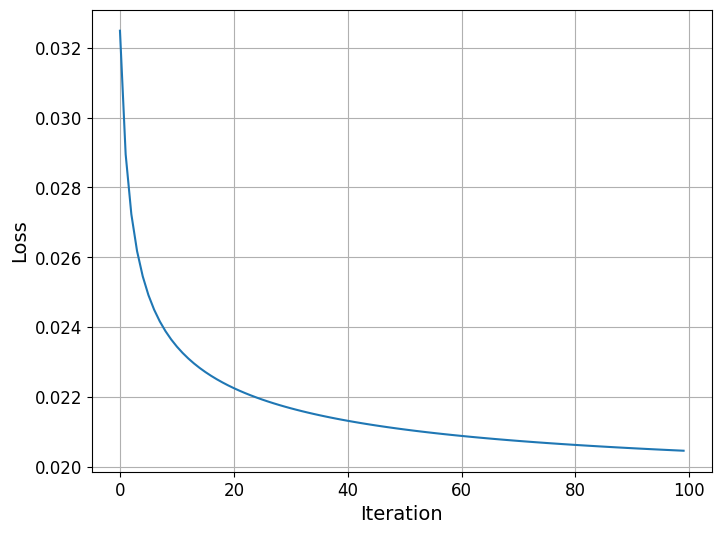

In [23]:
plt.figure()
plt.plot(np.arange(iterations),loss)
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

In [24]:
print('Training accuracy: %.2f'%bin_sgd.score(x_train,y_train_0))
print('Testing accuracy: %.2f'%bin_sgd.score(x_test,y_test_0))

Training accuracy: 0.99
Testing accuracy: 0.99


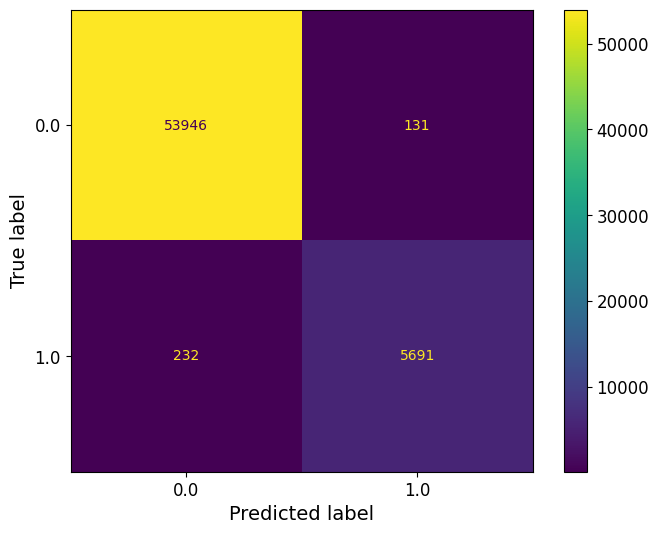

In [25]:
y_hat_train_0 = bin_sgd.predict(x_train)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0, y_hat_train_0, values_format='.5g')

In [26]:
print(classification_report(y_train_0, y_hat_train_0))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     54077
         1.0       0.98      0.96      0.97      5923

    accuracy                           0.99     60000
   macro avg       0.99      0.98      0.98     60000
weighted avg       0.99      0.99      0.99     60000



Cross validation to check the generalization ability of the model

In [27]:
import pprint
estimator = SGDClassifier(loss='log_loss',
                        penalty='l2',
                        max_iter=100,
                        warm_start=False,
                        eta0=0.01,
                        alpha=0,
                        learning_rate='constant',
                        random_state=1729)
cv_bin_clf = cross_validate(estimator, x_train, y_train_0, cv=5,
                            scoring=['precision', 'recall','f1'],
                            return_train_score=True,
                            return_estimator=True)
pprint.pprint(cv_bin_clf)

{'estimator': [SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log_loss',
              max_iter=100, random_state=1729),
               SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log_loss',
              max_iter=100, random_state=1729),
               SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log_loss',
              max_iter=100, random_state=1729),
               SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log_loss',
              max_iter=100, random_state=1729),
               SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log_loss',
              max_iter=100, random_state=1729)],
 'fit_time': array([2.20201468, 4.11368251, 2.32039285, 3.09236407, 1.91174126]),
 'score_time': array([0.04624701, 0.09990025, 0.04638433, 0.16882467, 0.07138562]),
 'test_f1': array([0.95699831, 0.954371  , 0.9616041 , 0.95870583, 0.95993252]),
 'test_precision': array([0.95538721, 0.96382429, 0.

In [28]:
weights = bin_sgd.coef_
bias = bin_sgd.intercept_
print('Dimention of Weights w: {0}'.format(weights.shape))
print("Bias: {0}".format(bias))

Dimention of Weights w: (1, 784)
Bias: [-4.89282893]


In [29]:
weights

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -5.91219936e-05, -4.94796883e-04, -5.70115692e-04,
        -5.70115692e-04,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -3.16534859e-07,
        -1.15867591e-05, -5.05756588e-05, -1.23562216e-04,
        -4.16452623e-04, -5.60306978e-03, -1.68487279e-02,
         2.47854731e-01,  5.28265609e-01,  2.26179837e-01,
        -2.43540984e-02,  2.97797073e-01,  8.50576356e-01,
         4.19325021e-01, -3.65121933e-03, -4.46186701e-03,
        -6.83860590e-03, -3.15004072e-03, -5.41504538e-0

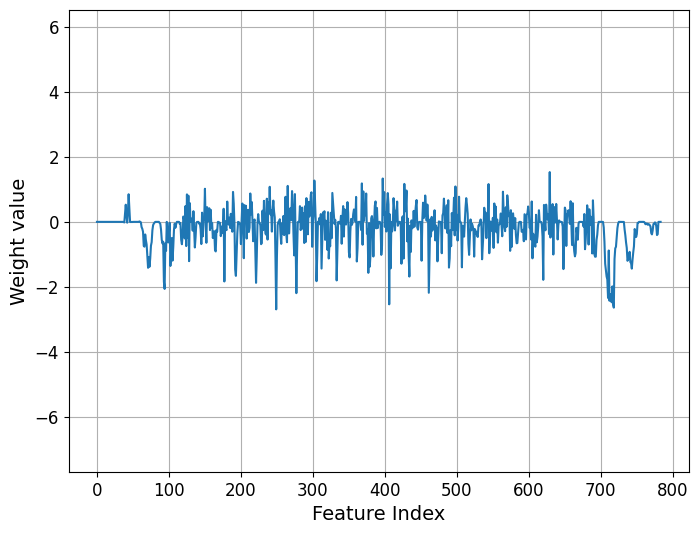

In [30]:
plt.figure()
plt.plot(np.arange(0,784), weights[0,:])
plt.xlabel('Feature Index')
plt.ylabel('Weight value')
plt.ylim(np.min(weights)-5, np.max(weights)+5)
plt.grid()

In [31]:
num_zero_w = weights.shape[1]-np.count_nonzero(weights)
print('number of weights with value zero: %f'%num_zero_w)

number of weights with value zero: 67.000000


Training with regularization


In [32]:
bin_sgd_clf_l2 = SGDClassifier(loss='log_loss',
                               penalty='l2',
                               alpha=0.001,
                               eta0=0.01,
                               max_iter=1,
                               warm_start=True,
                               learning_rate='constant',
                               random_state=1729)
loss=[]
iteration=100
for i in range(iteration):
  bin_sgd_clf_l2.fit(x_train,y_train_0)
  y_pred = bin_sgd_clf_l2.predict_proba(x_train)
  loss.append(log_loss(y_train_0, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic

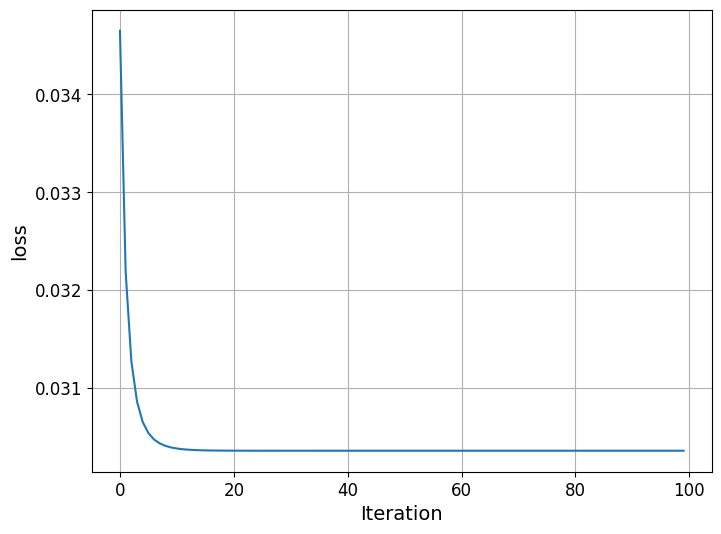

In [36]:
plt.figure()
plt.plot(np.arange(iteration), loss)
plt.xlabel('Iteration')
plt.ylabel("loss")
plt.grid()

In [34]:
weights = bin_sgd_clf_l2.coef_
bias = bin_sgd_clf_l2.intercept_
print(bias)

[-4.43002876]


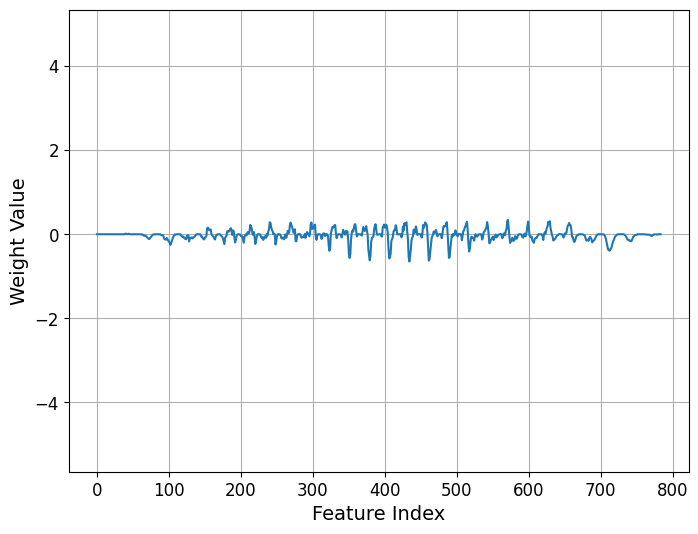

In [39]:
plt.figure()
plt.plot(np.arange(0,784), weights[0,:])
plt.xlabel('Feature Index')
plt.ylabel('Weight Value')
plt.ylim((np.min(weights)-5), np.max(weights)+5)
plt.grid()

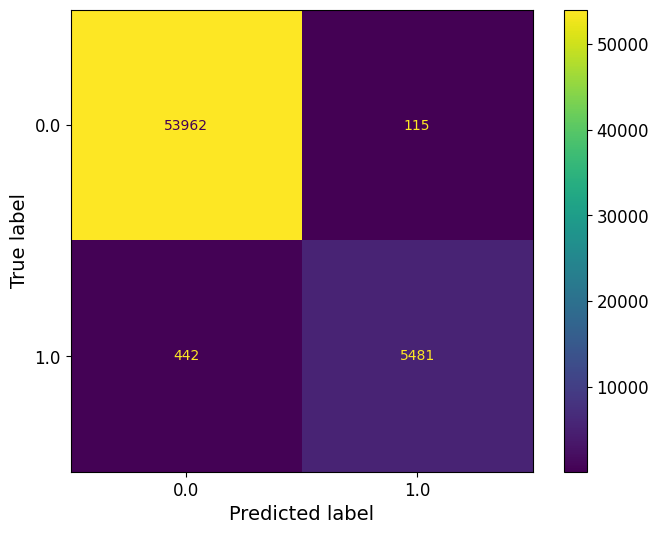

In [40]:
y_hat_train_0 = bin_sgd_clf_l2.predict(x_train)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0, y_hat_train_0, values_format='.5g')

In [41]:
print(classification_report(y_train_0, y_hat_train_0))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     54077
         1.0       0.98      0.93      0.95      5923

    accuracy                           0.99     60000
   macro avg       0.99      0.96      0.97     60000
weighted avg       0.99      0.99      0.99     60000



recall has gone down .96 -> .93

## Hyper parameter tuning

In [43]:
lr_grid = loguniform(1e-2,1e-1)

In [46]:
print(lr_grid.rvs(3, random_state=42))

[0.02368864 0.0892718  0.05395031]


In [48]:
estimator = SGDClassifier(loss='log_loss',
                          penalty = 'l2',
                          max_iter=1,
                          warm_start=True,
                          eta0=0.01,
                          alpha=0,
                          learning_rate='constant',
                          random_state=1729)

In [49]:
scores = RandomizedSearchCV(estimator,
                            param_distributions={'eta0':lr_grid},
                            cv=5,
                            scoring=['precision', 'recall', 'f1'],
                            n_iter=5,
                            refit='f1')

In [50]:
scores.fit(x_train, y_train_0)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic

RandomizedSearchCV(cv=5,
                   estimator=SGDClassifier(alpha=0, eta0=0.01,
                                           learning_rate='constant',
                                           loss='log_loss', max_iter=1,
                                           random_state=1729, warm_start=True),
                   n_iter=5,
                   param_distributions={'eta0': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7961e16be380>},
                   refit='f1', scoring=['precision', 'recall', 'f1'])

In [52]:
pprint.pprint(scores.cv_results_)

{'mean_fit_time': array([0.39993496, 0.44511609, 0.58338509, 0.63080516, 0.41902637]),
 'mean_score_time': array([0.06743889, 0.06998672, 0.10326166, 0.09263043, 0.06951952]),
 'mean_test_f1': array([0.95383975, 0.94148246, 0.94869555, 0.95090017, 0.95474878]),
 'mean_test_precision': array([0.96136672, 0.93597638, 0.94998271, 0.9540212 , 0.96640269]),
 'mean_test_recall': array([0.94682062, 0.94851138, 0.94834146, 0.94850966, 0.94361173]),
 'param_eta0': masked_array(data=[0.023688639503640783, 0.08927180304353628,
                   0.05395030966670229, 0.03968793330444373,
                   0.014322493718230255],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'eta0': 0.023688639503640783},
            {'eta0': 0.08927180304353628},
            {'eta0': 0.05395030966670229},
            {'eta0': 0.03968793330444373},
            {'eta0': 0.014322493718230255}],
 'rank_test_f1': array([2, 5, 4, 3, 1], dtype=int32)

In [56]:
best_bin_clf = scores.best_estimator_

In [57]:
y_hat_train_best_0 = best_bin_clf.predict(x_train)

In [58]:
print(classification_report(y_train_0, y_hat_train_best_0))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     54077
         1.0       0.98      0.92      0.95      5923

    accuracy                           0.99     60000
   macro avg       0.99      0.96      0.97     60000
weighted avg       0.99      0.99      0.99     60000



## Classification Report
**pricision/recall tradeoff**

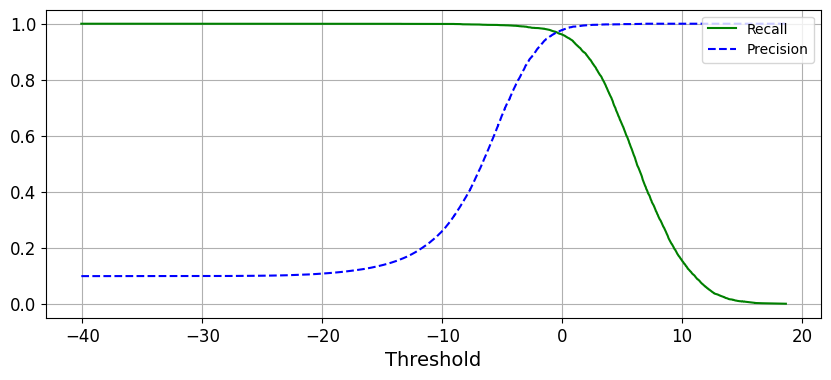

In [63]:
y_scores = bin_sgd.decision_function(x_train)
precisions, recalls, thresholds = precision_recall_curve(y_train_0, y_scores)
plt.figure(figsize=(10,4))
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.xlabel("Threshold")
plt.grid()
plt.legend(loc='upper right')


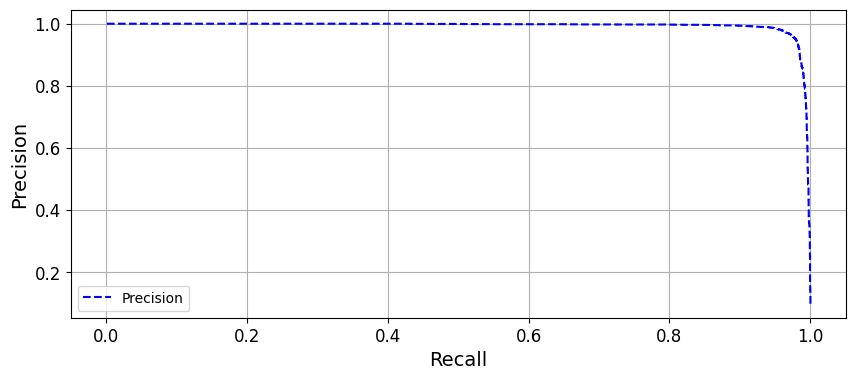

In [66]:
plt.figure(figsize=(10,4))
plt.plot(recalls[:-1], precisions[:-1], "b--", label='Precision')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.grid()
plt.legend()

**The ROC Curve**

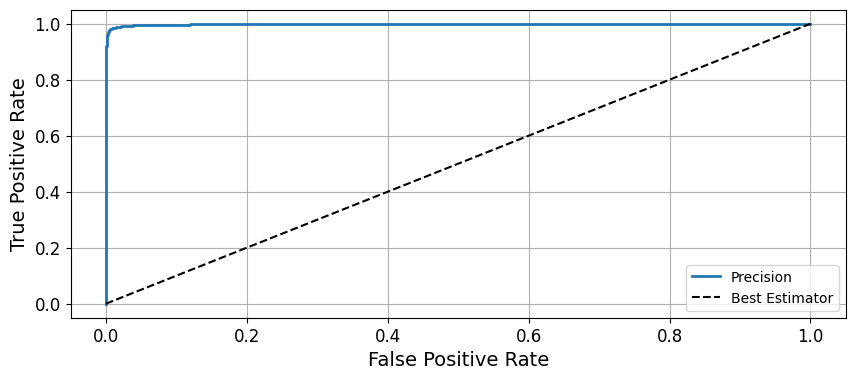

In [68]:
fpr, tpr, thresholds = roc_curve(y_train_0, y_scores)
plt.figure(figsize=(10,4))
plt.plot(fpr, tpr, linewidth=2, label='Precision')
plt.plot([0,1], [0, 1], 'k--', label='Best Estimator')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()